In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
%matplotlib inline

### Load Data From CSV File


In [2]:
df = pd.read_csv('C:/Users/Thales/Downloads/loan_train.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [3]:
df.shape

(346, 10)

### Convert to date time object


In [4]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [5]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


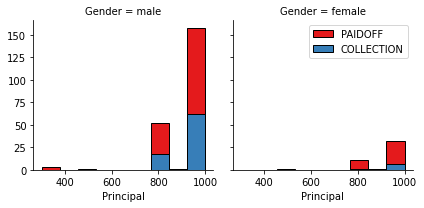

In [6]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

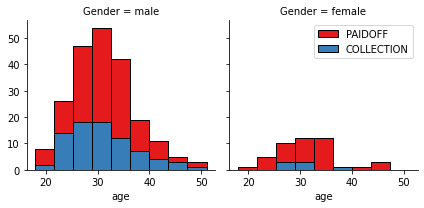

In [7]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


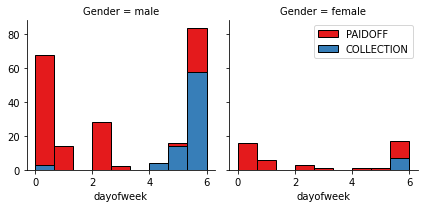

In [8]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [9]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [10]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [11]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [12]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [13]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [14]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [15]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [16]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [17]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


# Building model using KNN, finding the best k and accuracy evaluation 
Training & Predicting

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
k = 3
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
y_pred_KNN = neigh.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_pred_KNN))
print('KNN Model F1 Score',f1_score(y_test, y_pred_KNN, average='weighted'))

Train set Accuracy:  0.8369565217391305
Test set Accuracy:  0.7428571428571429
KNN Model F1 Score 0.7485119047619048


Not better than k=3

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
y_pred_KNN = neigh.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_pred_KNN))
print('KNN Model F1 Score',f1_score(y_test, y_pred_KNN, average='weighted'))

Train set Accuracy:  0.8188405797101449
Test set Accuracy:  0.7
KNN Model F1 Score 0.7212490479817212


Not better than k=3

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
k = 5
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
y_pred_KNN = neigh.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_pred_KNN))
print('KNN Model F1 Score',f1_score(y_test, y_pred_KNN, average='weighted'))

Train set Accuracy:  0.8188405797101449
Test set Accuracy:  0.7428571428571429
KNN Model F1 Score 0.7428571428571429


Not better than k=3

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
k = 6
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
y_pred_KNN = neigh.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_pred_KNN))
print('KNN Model F1 Score',f1_score(y_test, y_pred_KNN, average='weighted'))

Train set Accuracy:  0.7971014492753623
Test set Accuracy:  0.7142857142857143
KNN Model F1 Score 0.7298534798534798


Not better than k=3

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
k = 15
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
y_pred_KNN = neigh.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_pred_KNN))
print('KNN Model F1 Score',f1_score(y_test, y_pred_KNN, average='weighted'))

Train set Accuracy:  0.7644927536231884
Test set Accuracy:  0.6857142857142857
KNN Model F1 Score 0.6670522459996144


In [24]:
Ks=10 
mean_acc = np.zeros((Ks-1))
std_acc= np.zeros((Ks-1))
for n in range(1,Ks):
    Kn= KNeighborsClassifier(n_neighbors= n).fit(X_train,y_train)
    yhat =Kn.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
print(mean_acc)

[0.65714286 0.58571429 0.74285714 0.7        0.74285714 0.71428571
 0.78571429 0.75714286 0.75714286]


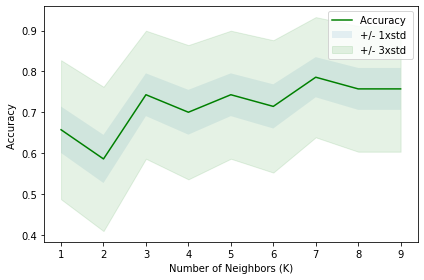

In [25]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [26]:
k = 7
#Train Model and Predict  
Kn = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
Kn

KNeighborsClassifier(n_neighbors=7)

In [27]:
yhat1 = Kn.predict(X_test)

In [28]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, Kn.predict(X_train)))
KNN_score=(print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat1)))

Train set Accuracy:  0.8079710144927537
Test set Accuracy:  0.7857142857142857


# Building model using Decision Tree and find the accuracy evaluation


In [29]:
from sklearn.tree import DecisionTreeClassifier
DTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

In [30]:
DTree.fit(X_train, y_train)
y_pred_DT= DTree.predict(X_test)

In [31]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test,y_pred_DT))
print('DTree Model F1 Score',f1_score(y_test, y_pred_DT, average='weighted'))

DecisionTrees's Accuracy:  0.6142857142857143
DTree Model F1 Score 0.6445993031358885


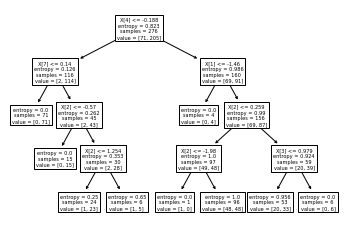

In [32]:
import sklearn.tree as tree
tree.plot_tree(DTree)
plt.show()

# Building model using Decision Tree and find the accuracy evaluation


In [33]:
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score


In [34]:
svm_model = svm.SVC(kernel='rbf')
svm_model.fit(X_train, y_train) 
y_pred_svm = svm_model.predict(X_test)

In [35]:
print('SVM Accuracy:', metrics.accuracy_score(y_test,y_pred_svm))
print('KNN Model F1 Score',f1_score(y_test, y_pred_svm, average='weighted'))

SVM Accuracy: 0.7428571428571429
KNN Model F1 Score 0.7275882012724117


# Building model using Logistic Regression and find the accuracy evaluation

In [36]:
from sklearn.linear_model import LogisticRegression

In [37]:
LR_Model = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
y_pred_lr = LR_Model.predict(X_test)

In [38]:
y_pred_lr_prob = LR_Model.predict_proba(X_test)

In [39]:
print('LR Accuracy:', metrics.accuracy_score(y_test,y_pred_lr))
print('LR logloss:', log_loss(y_test, y_pred_lr_prob))

LR Accuracy: 0.6857142857142857
LR logloss: 0.5772287609479654


# Model Evaluation using Test set

In [40]:
test_df = pd.read_csv('C:/Users/Thales/Downloads/loan_test.csv')
test_df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [41]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [42]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] =test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [43]:
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [44]:
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
test_X = preprocessing.StandardScaler().fit(Feature_test).transform(Feature_test)
test_X[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

In [45]:
test_y=test_df['loan_status'].values
test_y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [46]:
knn_yhat = Kn.predict(test_X)
Tree_yhat=DTree.predict(test_X)
SVM_yhat=svm_model.predict(test_X)
LR_yhat=LR_Model.predict(test_X)

In [47]:
import sklearn
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import jaccard_score

In [48]:
# jaccrd_score
print('jaccrd_score')

KNN_jscore =(print('KNN_j score: %.2f' % jaccard_score(test_y, knn_yhat,pos_label = "PAIDOFF")))
Tree_jscore =(print('Tree_j score: %.2f' % jaccard_score(test_y, Tree_yhat,pos_label = "PAIDOFF")))
SVM_jscore =(print('SVM_j score: %.2f' %jaccard_score(test_y, SVM_yhat,pos_label = "PAIDOFF")))
LR_jscore =(print('LR_j score: %.2f' %jaccard_score(test_y,LR_yhat,pos_label = "PAIDOFF")))

jaccrd_score
KNN_j score: 0.67
Tree_j score: 0.66
SVM_j score: 0.78
LR_j score: 0.74


In [49]:
#f1_score
print('f1_score')
KNN_f1=print('KNN_f1 score: %.2f' %f1_score(test_y, knn_yhat, average='weighted') )
Tree_f1=print('Tree_f1 score: %.2f' %f1_score(test_y, Tree_yhat, average='weighted') )
SVM_f1=print('SVM_f1 score: %.2f' %f1_score(test_y, SVM_yhat, average='weighted') )
LR_f1=print('LR_f1 score: %.2f' %f1_score(test_y,LR_yhat, average='weighted') )

f1_score
KNN_f1 score: 0.66
Tree_f1 score: 0.74
SVM_f1 score: 0.76
LR_f1 score: 0.66


In [50]:
# Logloss
print('log_loss')
LR_yhat_log = LR_Model.predict_proba(test_X)
LR_logloss=print('LR_f1 score: %.2f' %log_loss(test_y,LR_yhat_log) )

log_loss
LR_f1 score: 0.57


In [51]:
list_scores ={'Alogrithm':['KNN','Decision Tree','SVM','LogisticRegression'],'Jaccard':[0.67,0.72,0.80,0.74],'F1_score':[0.63,0.74,0.76,0.66],
              'Logloss':['NA','NA','NA',0.57]}
list_score=pd.DataFrame(list_scores)
list_score

,Alogrithm,Jaccard,F1_score,Logloss
0,KNN,0.67,0.63,NA
1,Decision Tree,0.72,0.74,NA
2,SVM,0.80,0.76,NA
3,LogisticRegression,0.74,0.66,0.57
